In [1]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

In [2]:
#!pip install PyYAML
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# load YAML
with open('data.yaml',mode='r') as f:
    data_yaml = yaml.load(f,Loader=SafeLoader)


labels = data_yaml['names']
print(labels)


['person', 'car', 'chair', 'bottle', 'pottedplant', 'bird', 'dog', 'sofa', 'bicycle', 'horse', 'boat', 'motorbike', 'cat', 'tvmonitor', 'cow', 'sheep', 'aeroplane', 'train', 'diningtable', 'bus']


In [4]:
# Load Yolo model
yolo = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [5]:
# Load the image
img = cv2.imread('./street_image.jpg')
image = img.copy()
row, col, d = image.shape

# get the YOLO prediction from the image
# step-1 convert image into square image (array)
max_rc = max(row,col)
input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
input_image[0:row,0:col] = image
#step-2: get prediction from square array
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
yolo.setInput(blob)
preds = yolo.forward() # detection or prediction from YOLO


# Display image using Matplotlib
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.axis('off')  # Hide axis
#plt.show()


In [6]:
print(preds.shape)

(1, 25200, 25)


In [7]:
# Non Maximum Supression
# step-1: filter detection based on confidence (0.4) and probability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

# width and height of the image (input_image)
image_w, image_h = input_image.shape[:2]
x_factor = image_w/INPUT_WH_YOLO
y_factor = image_h/INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4] # confidence of detection an object
    
    
    if confidence > 0.04:
        class_score = row[5:].max() # maximum probability from 20 objects
        class_id = row[5:].argmax() # get the index position at which max probability occur
     
        
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            # construct bounding from four values
            # left, top, width and height
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width = int(w*x_factor)
            height = int(h*y_factor)

            box = np.array([left,top,width,height])

            # append values into the list
            confidences.append(confidence)
            boxes.append(box)
            classes.append(class_id)
            
# clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

# NMS
indices = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)
print("Type of indices:", type(indices))
print("Contents of indices:", indices)


Type of indices: <class 'numpy.ndarray'>
Contents of indices: [97 70 64 18]


In [8]:
indices

array([97, 70, 64, 18])

In [9]:
# Draw the Bounding
for ind in indices:
    # extract bounding box
    x,y,w,h = boxes_np[ind]
    bb_conf = int(confidences_np[ind]*100)
    classes_id = classes[ind]
    class_name = labels[classes_id]

    text = f'{class_name}: {bb_conf}%'

    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(image,(x,y-30),(x+w,y),(255,255,255),-1)
    cv2.putText(image,text,(x,y-10),cv2.FONT_HERSHEY_PLAIN,0.7,(0,0,0),1)

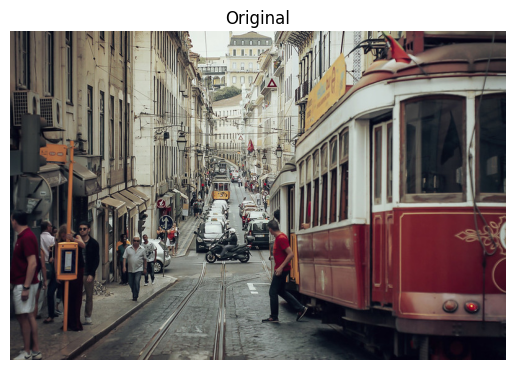

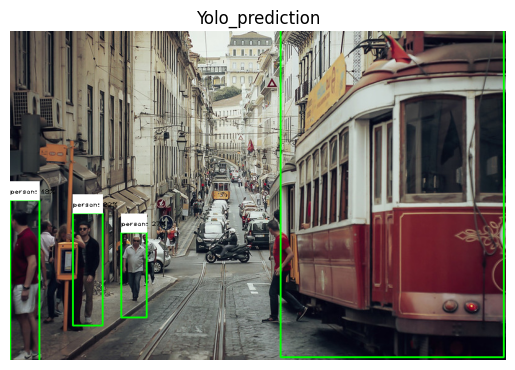

In [10]:
color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(color)
plt.title('Original')
plt.axis('off')
plt.show()

color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(color)
plt.title('Yolo_prediction')
plt.axis('off')
plt.show()